In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from joblib import parallel_backend
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from hummingbird.ml import convert, load

C:\Users\Pabma\AppData\Local\Temp\ipykernel_27632\3539060139.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
conn = psycopg2.connect(dbname='TFM_Coches', user='postgres', password='9170', host='127.0.0.1', port='5432')


In [4]:
cursor = conn.cursor()
query = """
    SELECT v.price_amount, ft.makeid, ft.manufacturerprice, v.km, ft.vehicleyear,
           v.etiqueta_type_id, p.provinceid, ft.horsepower, ft.maxspeed, ft.acceleration,
           com.combustible_type_id, b.body_type_id, t.transmision_type_id,
           ft.doors, ft.seatingcapacity, c.colores_type_id,
           ft.dimensionsinmillimeterswidth, ft.dimensionsinmillimetersheight,
           ft.dimensionsinmillimeterslength, ft.weight,
           ft.tankcapacityinliters, ft.trunkcapacityinliters,
           ft.consumptionurban, ft.consumptionmixed, ft.consumptionextraurban,
           ft.co2emissionsgramsperkm, ft.batteryvoltage, ft.batterykwh,
           ft.chargingtime, ft.chargingtimefast
    FROM ventas v
    INNER JOIN provincias p ON v.provinceid = p.provinceid
    INNER JOIN fichas_tecnicas ft ON v.ficha_id = ft.id
    INNER JOIN colores c ON ft.vehiclecolorid = c.colores_type_id
    INNER JOIN transmision t ON ft.transmissiontypeid = t.transmision_type_id
    INNER JOIN bodytype b ON ft.bodytypeid = b.body_type_id
    INNER JOIN combustible com ON ft.fueltypeid = com.combustible_type_id
    INNER JOIN etiqueta_medioambiental em ON v.etiqueta_type_id = em.etiqueta_type_id
    INNER JOIN marcas m ON ft.makeid = m.makeid;
"""

# Ejecutar la consulta y guardar los resultados en un DataFrame de pandas
ventas_df = pd.read_sql(query, conn)

# Mostrar los primeros registros del DataFrame
print(ventas_df.head())

# Guardar el DataFrame como un archivo CSV
ventas_df.to_csv('ventas_dataframe.csv', index=False)

# Cerrar la conexión
cursor.close()
conn.close()

C:\Users\Pabma\AppData\Local\Temp\ipykernel_35248\198567699.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ventas_df = pd.read_sql(query, conn)


  price_amount  makeid manufacturerprice      km vehicleyear  \
0         9599      77             21625  152720        2018   
1         9990      22             21920  141485        2015   
2         9990      22             21920  141485        2015   
3         9900      84             14900  129000        2016   
4         8460      90             15060  117000        2018   

   etiqueta_type_id  provinceid horsepower maxspeed acceleration  ...  \
0                 1          41        110      195           11  ...   
1                 1          46         99      180         11.5  ...   
2                 1          30         99      180         11.5  ...   
3                 5          28         75      168         14.3  ...   
4                 1          46         75      167         14.7  ...   

   tankcapacityinliters  trunkcapacityinliters  consumptionurban  \
0                    48                    370               4.2   
1                    60                 

In [5]:
# Obtener los tipos de datos de cada columna
tipos_de_dato = ventas_df.dtypes
# Imprimir los tipos de datos
print(tipos_de_dato)

price_amount                     object
makeid                            int64
manufacturerprice                object
km                               object
vehicleyear                      object
etiqueta_type_id                  int64
provinceid                        int64
horsepower                       object
maxspeed                         object
acceleration                     object
combustible_type_id               int64
body_type_id                      int64
transmision_type_id               int64
doors                            object
seatingcapacity                  object
colores_type_id                   int64
dimensionsinmillimeterswidth     object
dimensionsinmillimetersheight    object
dimensionsinmillimeterslength    object
weight                           object
tankcapacityinliters             object
trunkcapacityinliters            object
consumptionurban                 object
consumptionmixed                 object
consumptionextraurban            object


In [6]:
ventas_df['price_amount'] = pd.to_numeric(ventas_df['price_amount'], errors='coerce')
ventas_df['manufacturerprice'] = pd.to_numeric(ventas_df['manufacturerprice'], errors='coerce')
ventas_df['km'] = pd.to_numeric(ventas_df['km'], errors='coerce')
ventas_df['vehicleyear'] = pd.to_numeric(ventas_df['vehicleyear'], errors='coerce')
ventas_df['horsepower'] = pd.to_numeric(ventas_df['horsepower'], errors='coerce')
ventas_df['maxspeed'] = pd.to_numeric(ventas_df['maxspeed'], errors='coerce')
ventas_df['acceleration'] = pd.to_numeric(ventas_df['acceleration'], errors='coerce')
ventas_df['doors'] = pd.to_numeric(ventas_df['doors'], errors='coerce')
ventas_df['seatingcapacity'] = pd.to_numeric(ventas_df['seatingcapacity'], errors='coerce')
ventas_df['dimensionsinmillimeterswidth'] = pd.to_numeric(ventas_df['dimensionsinmillimeterswidth'], errors='coerce')
ventas_df['dimensionsinmillimetersheight'] = pd.to_numeric(ventas_df['dimensionsinmillimetersheight'], errors='coerce')
ventas_df['dimensionsinmillimeterslength'] = pd.to_numeric(ventas_df['dimensionsinmillimeterslength'], errors='coerce')
ventas_df['weight'] = pd.to_numeric(ventas_df['weight'], errors='coerce')
ventas_df['trunkcapacityinliters'] = pd.to_numeric(ventas_df['trunkcapacityinliters'], errors='coerce')
ventas_df['tankcapacityinliters'] = pd.to_numeric(ventas_df['tankcapacityinliters'], errors='coerce')
ventas_df['consumptionurban'] = pd.to_numeric(ventas_df['consumptionurban'], errors='coerce')
ventas_df['consumptionmixed'] = pd.to_numeric(ventas_df['consumptionmixed'], errors='coerce')
ventas_df['consumptionextraurban'] = pd.to_numeric(ventas_df['consumptionextraurban'], errors='coerce')
ventas_df['co2emissionsgramsperkm'] = pd.to_numeric(ventas_df['co2emissionsgramsperkm'], errors='coerce')
ventas_df['batteryvoltage'] = pd.to_numeric(ventas_df['batteryvoltage'], errors='coerce')
ventas_df['batterykwh'] = pd.to_numeric(ventas_df['batterykwh'], errors='coerce')
ventas_df['chargingtime'] = pd.to_numeric(ventas_df['chargingtime'], errors='coerce')
ventas_df['chargingtimefast'] = pd.to_numeric(ventas_df['chargingtimefast'], errors='coerce')

In [2]:
ventas_df['makeid'] = ventas_df['makeid'].astype('category')
ventas_df['etiqueta_type_id'] = ventas_df['etiqueta_type_id'].astype('category')
ventas_df['provinceid'] = ventas_df['provinceid'].astype('category')
ventas_df['transmision_type_id'] = ventas_df['transmision_type_id'].astype('category')
ventas_df['body_type_id'] = ventas_df['body_type_id'].astype('category')
ventas_df['combustible_type_id'] = ventas_df['combustible_type_id'].astype('category')
ventas_df['colores_type_id'] = ventas_df['colores_type_id'].astype('category')

# Mostrar los niveles de cada columna categórica
print(ventas_df['makeid'].cat.categories)
print(ventas_df['etiqueta_type_id'].cat.categories)
print(ventas_df['provinceid'].cat.categories)
print(ventas_df['transmision_type_id'].cat.categories)
print(ventas_df['body_type_id'].cat.categories)
print(ventas_df['combustible_type_id'].cat.categories)
print(ventas_df['colores_type_id'].cat.categories)

NameError: name 'ventas_df' is not defined

In [8]:
print(ventas_df.head())

   price_amount makeid  manufacturerprice        km  vehicleyear  \
0          9599     77            21625.0  152720.0         2018   
1          9990     22            21920.0  141485.0         2015   
2          9990     22            21920.0  141485.0         2015   
3          9900     84            14900.0  129000.0         2016   
4          8460     90            15060.0  117000.0         2018   

  etiqueta_type_id provinceid  horsepower  maxspeed  acceleration  ...  \
0                1         41       110.0     195.0          11.0  ...   
1                1         46        99.0     180.0          11.5  ...   
2                1         30        99.0     180.0          11.5  ...   
3                5         28        75.0     168.0          14.3  ...   
4                1         46        75.0     167.0          14.7  ...   

  tankcapacityinliters trunkcapacityinliters consumptionurban  \
0                 48.0                 370.0              4.2   
1               

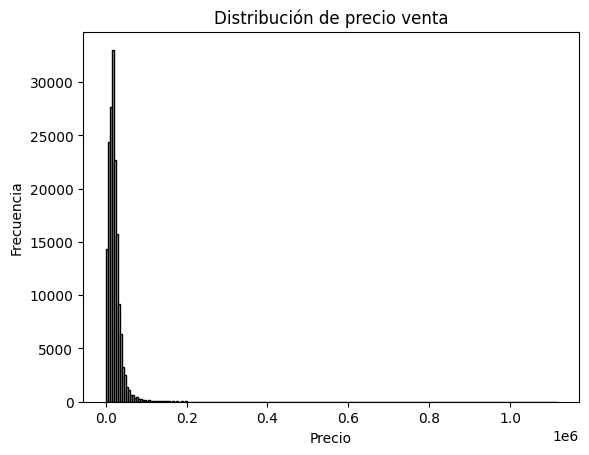

In [9]:
plt.hist(ventas_df['price_amount'], bins=range(0, int(max(ventas_df['price_amount'])) + 5000, 5000), color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.title('Distribución de precio venta')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

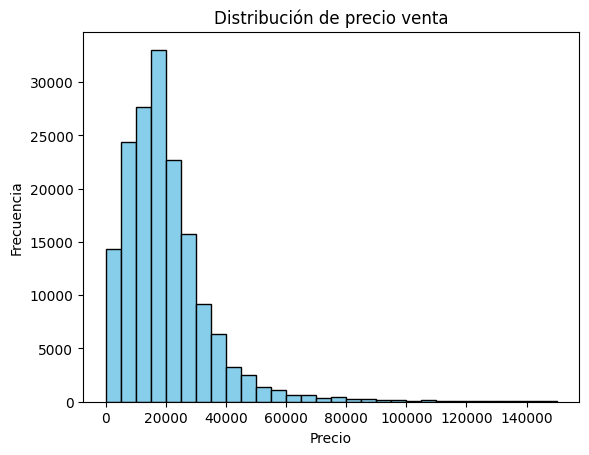

In [10]:
ventas_df = ventas_df[ventas_df['price_amount'] <= 150000]

# Crear el histograma
plt.hist(ventas_df['price_amount'], bins=range(0, int(max(ventas_df['price_amount'])) + 5000, 5000), color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.title('Distribución de precio venta')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

In [11]:
ventas_df_combustible = ventas_df[ventas_df['combustible_type_id'].astype(str) == "2"]

ventas_df_combustible['lPrice'] = np.log10(ventas_df_combustible['price_amount'])

# Eliminar las columnas batteryvoltage, batterykwh, chargingtimefast y chargingtime
ventas_df_combustible = ventas_df_combustible.drop(columns=['batteryvoltage', 'batterykwh', 'chargingtimefast', 'chargingtime', 'price_amount'])
# Mostrar el dataframe resultante
print(ventas_df_combustible)

       makeid  manufacturerprice        km  vehicleyear etiqueta_type_id  \
4          90            15060.0  117000.0         2018                1   
24        105            22775.0   94000.0         2019                1   
27         77            17050.0   63992.0         2019                5   
30         22            14050.0   89950.0         2016                1   
32         90            15060.0   63000.0         2018                5   
...       ...                ...       ...          ...              ...   
165743     68                NaN   20000.0         2001                2   
165746     41                NaN  183000.0         2003                2   
165747     22                NaN   10000.0         1982                2   
165750     10            30954.0  138600.0         2017                1   
165753     77            18400.0  188000.0         2006                1   

       provinceid  horsepower  maxspeed  acceleration combustible_type_id  \
4         

C:\Users\Pabma\AppData\Local\Temp\ipykernel_35248\1442615485.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventas_df_combustible['lPrice'] = np.log10(ventas_df_combustible['price_amount'])


In [15]:

print(ventas_df_combustible_imputed.columns)

Index(['makeid', 'manufacturerprice', 'km', 'vehicleyear', 'etiqueta_type_id',
       'provinceid', 'horsepower', 'maxspeed', 'acceleration',
       'combustible_type_id', 'body_type_id', 'transmision_type_id', 'doors',
       'seatingcapacity', 'colores_type_id', 'dimensionsinmillimeterswidth',
       'dimensionsinmillimetersheight', 'dimensionsinmillimeterslength',
       'weight', 'tankcapacityinliters', 'trunkcapacityinliters',
       'consumptionurban', 'consumptionmixed', 'consumptionextraurban',
       'co2emissionsgramsperkm', 'lPrice'],
      dtype='object')


In [10]:
# Dividir el conjunto de datos en entrenamiento y prueba

#Solo la primera vez
#ventas_df_combustible_imputed = ventas_df_combustible_imputed.drop(columns='price_amount')

X = ventas_df_combustible_imputed.drop(columns=['lPrice'])
y = ventas_df_combustible_imputed['lPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=123)


k1, k2 = 5, 1
rfk = RepeatedKFold(n_splits=k1, n_repeats=k2, random_state= 456)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def rsq(y_true, y_pred):
    return r2_score(y_true, y_pred)

numeric_features = X_train.select_dtypes(include=['int', 'float']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('yeo_johnson', PowerTransformer(method='yeo-johnson'), ['km']),
        ('scaling', StandardScaler(), numeric_features)
    ])


In [12]:
rf_model = RandomForestRegressor(n_estimators=1000, min_samples_leaf=15)

# Pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf_model)])

# Entrenar el modelo
with parallel_backend('threading', n_jobs=8):
    rf_pipeline.fit(X_train, y_train)

In [13]:
y_pred = rf_pipeline.predict(X_test)
rmse_value = rmse(y_test, y_pred)
mae_value = mae(y_test, y_pred)
rsq_value = rsq(y_test, y_pred)
metricS = {'RMSE': rmse_value, 'MAE': mae_value, 'R^2': rsq_value}

In [14]:
print(metricS)

{'RMSE': 0.11241113139121767, 'MAE': 0.06342943299896471, 'R^2': 0.8830225509227916}


In [20]:
# Definir los parámetros que quieres ajustar y sus posibles valores
param_grid = {
    'n_estimators': [100, 500, 1000],
    'min_samples_leaf': [10, 15, 20]
}

rf_model = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
with parallel_backend('threading', n_jobs=5):
    grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

Mejores parámetros: {'min_samples_leaf': 10, 'n_estimators': 500}


In [21]:
print(best_rf_model)
y_train_pred = grid_search.best_estimator_.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
r2_train = r2_score(y_train, y_train_pred)
print("MAE (Entrenamiento):", mae_train)
print("RMSE (Entrenamiento):", rmse_train)
print("R^2 (Entrenamiento):", r2_train)

RandomForestRegressor(min_samples_leaf=10, n_estimators=500)
MAE (Entrenamiento): 0.04924409406030166
RMSE (Entrenamiento): 0.08896777440775139
R^2 (Entrenamiento): 0.9258526653281272


C:\Users\Pabma\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
print(best_rf_model)
y_test_pred = grid_search.best_estimator_.predict(X_test)
mae_train = mean_absolute_error(y_test, y_test_pred)
rmse_train = mean_squared_error(y_test, y_test_pred, squared=False)
r2_train = r2_score(y_test, y_test_pred)
print("MAE (Test):", mae_train)
print("RMSE (Test):", rmse_train)
print("R^2 (Test):", r2_train)

RandomForestRegressor(min_samples_leaf=10, n_estimators=500)
MAE (Test): 0.0616326636277965
RMSE (Test): 0.11029264462187216
R^2 (Test): 0.8873900904627705


C:\Users\Pabma\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [25]:
import pickle

# Obtener todas las variables locales en el ámbito actual
variables = locals()

# Guardar las variables en un archivo pickle
with open('variables.pkl', 'wb') as f:
    pickle.dump(variables, f)

TypeError: cannot pickle 'module' object

In [30]:
import pickle

# Crear un diccionario con las variables que deseas guardar
variables_a_guardar = {'grid_search': grid_search, 'rf_pipeline': rf_pipeline, 'ventas_df': ventas_df, 'ventas_df_combustible': ventas_df_combustible, 'ventas_df_combustible_imputed': ventas_df_combustible_imputed}

# Guardar las variables en un archivo pickle
with open('variables.pkl', 'wb') as f:
    pickle.dump(variables_a_guardar, f)


In [3]:
import pickle

# Cargar las variables desde el archivo pickle
with open('variables.pkl', 'rb') as f:
    variables_cargadas = pickle.load(f)

# Asignar las variables cargadas a las variables locales
ventas_df = variables_cargadas['ventas_df']
grid_search = variables_cargadas['grid_search']
ventas_df_combustible_imputed = variables_cargadas['ventas_df_combustible_imputed']
ventas_df_combustible = variables_cargadas['ventas_df_combustible']
# Ahora puedes usar las variables cargadas en tu código
print(ventas_df.columns)
print("Mejores parámetros:", grid_search.best_params_)

Index(['price_amount', 'makeid', 'manufacturerprice', 'km', 'vehicleyear',
       'etiqueta_type_id', 'provinceid', 'horsepower', 'maxspeed',
       'acceleration', 'combustible_type_id', 'body_type_id',
       'transmision_type_id', 'doors', 'seatingcapacity', 'colores_type_id',
       'dimensionsinmillimeterswidth', 'dimensionsinmillimetersheight',
       'dimensionsinmillimeterslength', 'weight', 'tankcapacityinliters',
       'trunkcapacityinliters', 'consumptionurban', 'consumptionmixed',
       'consumptionextraurban', 'co2emissionsgramsperkm', 'batteryvoltage',
       'batterykwh', 'chargingtime', 'chargingtimefast'],
      dtype='object')
Mejores parámetros: {'min_samples_leaf': 10, 'n_estimators': 500}


In [ ]:
%who

In [ ]:
%whos

In [ ]:
dir()

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from hummingbird.ml import convert
X, y = load_breast_cancer(return_X_y=True)
skl_model = RandomForestClassifier(n_estimators=500, max_depth=7)

In [5]:
skl_model.fit(X, y)
pred = skl_model.predict(X)

In [6]:
model = convert(skl_model, 'torch')
pred_cpu_hb = model.predict(X)

In [7]:
model.to('cuda')
pred_gpu_hb = model.predict(X)

In [ ]:
rf_model_gpu = convert(rf_model, 'torch', extra_config={'tree_implementation': 'gemm'})
rf_model_gpu.to('cuda')
with parallel_backend('threading', n_jobs=3):
    rf_model_gpu.fit(X_train, y_train)

In [16]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4060 Laptop GPU


In [22]:
rf_model_gpu = convert(rf_model, 'torch', extra_config={'tree_implementation': 'gemm'})
rf_model_gpu.to('cuda')
if next(rf_model_gpu.parameters()).is_cuda:
    print("El modelo está siendo ejecutado en la GPU.")
else:
    print("El modelo está siendo ejecutado en la CPU.")